**Columns**

1. id - a unique identifier for each tweet
2. text - the text of the tweet
3. location - the location the tweet was sent from (may be blank)
4. keyword - a particular keyword from the tweet (may be blank)
5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

**Evaluation metric: F1 Score**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
print(train.head(3))
print(train.shape)

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  
0       1  
1       1  
2       1  
(7613, 5)


In [3]:
test = pd.read_csv('test.csv')
print(test.head(3))
print(test.shape)

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
(3263, 4)


In [4]:
sample= pd.read_csv('sample_submission.csv')
print(sample.head(3))
print(sample.shape)

   id  target
0   0       0
1   2       0
2   3       0
(3263, 2)


# EDA

In [5]:
train['target'].value_counts() #data is approximately balanced.

0    4342
1    3271
Name: target, dtype: int64

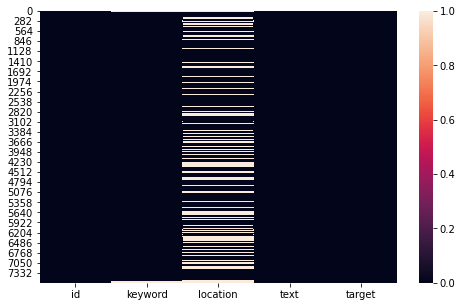

In [6]:
# Checking the null values.
fig = plt.figure(figsize = (8,5))
sns.heatmap(train.isnull())

In [7]:
train['keyword'].isnull().value_counts() # 61 values out of 7613 are missing in the 'keyword' column.

False    7552
True       61
Name: keyword, dtype: int64

In [8]:
train['location'].isnull().value_counts() # 2533 values out of 7613 are missing in the 'location' column.

False    5080
True     2533
Name: location, dtype: int64

In [9]:
train['location'].nunique()

3341

In [10]:
train['keyword'].unique()[:50] # there are 221 unique values including nan.

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide'], dtype=object)

**From this sample we can see that there are many values in this column which mean the same and therefore should be replaced by a common word (Stemming). Some values have '%20' in them which will be replaced by " ".**

In [11]:
real = train[train['target'] == 1] # creating separate dataframes for both the classes to do class specific analysis.
fake = train[train['target'] == 0]

In [12]:
real['location'].nunique() # we can see that only 1513 out of 3341 unique locations are in real data.

1513

**We can see that only 1513 out of 3341 unique locations are in real data. So, intuitively, we can build a simple classifier (for the given data) using if else saying that:**

**If the location of the query point is in the 1513 unique values then the tweet is real else it is fake.**

**But this is not really a proper logical solution to our problem as there will be some locations that will be common in both the datasets.**

In [13]:
fake['location'].nunique()

2142

**From this we can see that there are 314 common locations in both the datasets.**

In [14]:
train[train['keyword'].isnull()==True].head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
train[train['keyword'].isnull()==True]['target'].value_counts()

1    42
0    19
Name: target, dtype: int64

In [16]:
train[train['location'].isnull()==True]['target'].value_counts()

0    1458
1    1075
Name: target, dtype: int64

In [17]:
# creating a new dataframe that consists on non null values of the keywords
keywords = pd.DataFrame(train[train['keyword'].isnull()== False]['keyword'])
keywords.head()

,keyword
31,ablaze
32,ablaze
33,ablaze
34,ablaze
35,ablaze


# Preprocessing

In [18]:
processed_key = []
for word in tqdm(train['keyword'].values):
    key = str(word).replace("%20"," ")
    processed_key.append(key)

100%|██████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 691961.09it/s]


**As keywords are usually the main cause of the disaster so they can be important for us. Therefore to use them effecticely we can add then to our text column and this will help us create a corpus that has all the words as well as keywords.**

**Now I'll replace the keywords column in train with the preprocessed_keys.**

In [19]:
train['processed_keys'] = processed_key

In [20]:
train.drop(labels= 'keyword',inplace = True,axis = 1)

In [21]:
train.head()

,id,location,text,target,processed_keys
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,nan
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,nan
2,5,NaN,All residents asked to 'shelter in place' are ...,1,nan
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,nan
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,nan


In [22]:
train.drop([15,30,5115],inplace = True)#dropping these rows as text values in these data point turn into null on preprocessing 

## Training and modeling only on keywords.

In [23]:
# TRAIN TEST SPLIT OF THE KEYWORD COLUMN IN 75:25 RATIO.
xktrain, xktest, yktrain, yktest = train_test_split(train['processed_keys'],train['target'], test_size=0.25)
print(xktrain.shape, xktest.shape)

(5707,) (1903,)


In [24]:
# BAG OF WORDS ON KEYWORDS
bow_keys = CountVectorizer()
bow_keys.fit(train['processed_keys'])
xktrain_bow = bow_keys.transform(xktrain)
xktest_bow = bow_keys.transform(xktest)
print(xktrain_bow.shape,xktest_bow.shape)

(5707, 230) (1903, 230)


In [25]:
# CREATING DATAFRAMES FOR BAG OF WORD VECTORS SO AS TO USE THEM IN FUTURE WITH "TEXT" CORPUS.
dfk_train_bow = pd.DataFrame(xktrain_bow.todense(),columns= bow_keys.get_feature_names())
dfk_test_bow = pd.DataFrame(xktest_bow.todense(),columns= bow_keys.get_feature_names())
print(dfk_train_bow.shape,dfk_test_bow.shape)

(5707, 230) (1903, 230)


In [26]:
# TFIDF ON KEYWORDS
tfidf_keys = TfidfVectorizer()
tfidf_keys.fit(train['processed_keys'])
xktrain_tfidf = tfidf_keys.transform(xktrain)
xktest_tfidf= tfidf_keys.transform(xktest)
print(xktrain_tfidf.shape,xktest_tfidf.shape)

(5707, 230) (1903, 230)


In [27]:
# CREATING DATAFRAMES FOR TFIDF VECTORS SO AS TO USE THEM IN FUTURE WITH "TEXT" CORPUS.
dfk_train_tfidf = pd.DataFrame(xktrain_tfidf.todense(),columns= tfidf_keys.get_feature_names())
dfk_test_tfidf = pd.DataFrame(xktest_tfidf.todense(),columns= tfidf_keys.get_feature_names())
print(dfk_train_tfidf.shape,dfk_test_tfidf.shape)

(5707, 230) (1903, 230)


**I have majorly used linear models here as they tend to perform better on presence of high dimensional data.**

In [28]:
# LOGISTIC REGRESSION ON BOW
lr_key_bow = LogisticRegression(solver = 'liblinear')
lr_key_bow.fit(xktrain_bow,yktrain)
lr_key_bow_pred= lr_key_bow.predict(xktest_bow)
print(classification_report(yktest,lr_key_bow_pred))
# print(sns.heatmap(confusion_matrix(yktest,lr_key_bow_pred),cmap= 'coolwarm',annot = True))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1088
           1       0.70      0.65      0.67       815

    accuracy                           0.73      1903
   macro avg       0.73      0.72      0.72      1903
weighted avg       0.73      0.73      0.73      1903



In [29]:
# LOGISTIC REGRESSION ON TFIDF
lr_key_tfidf = LogisticRegression(solver = 'liblinear')
lr_key_tfidf.fit(xktrain_tfidf,yktrain)
lr_key_tfidf_pred= lr_key_tfidf.predict(xktest_tfidf)
print(classification_report(yktest,lr_key_tfidf_pred))
# print(sns.heatmap(confusion_matrix(yktest,lr_key_tfidf_pred),cmap= 'coolwarm',annot = True))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1088
           1       0.70      0.65      0.67       815

    accuracy                           0.73      1903
   macro avg       0.73      0.72      0.72      1903
weighted avg       0.73      0.73      0.73      1903



In [30]:
# LINEAR SVM ON BOW                       --> RBF SVM PERFORMED VERY POORLY ON THIS DATA
svm_key_bow = SVC(kernel = 'linear')
svm_key_bow.fit(xktrain_bow,yktrain)
svm_key_bow_pred= svm_key_bow.predict(xktest_bow)
print(classification_report(yktest,svm_key_bow_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1088
           1       0.71      0.64      0.67       815

    accuracy                           0.73      1903
   macro avg       0.73      0.72      0.72      1903
weighted avg       0.73      0.73      0.73      1903



In [31]:
# LINEAR SVM ON TFIDF                      --> RBF SVM PERFORMED VERY POORLY ON THIS DATA
svm_key_tfidf= SVC(kernel = 'linear')
svm_key_tfidf.fit(xktrain_tfidf,yktrain)
svm_key_tfidf_pred= svm_key_tfidf.predict(xktest_tfidf)
print(classification_report(yktest,svm_key_tfidf_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1088
           1       0.70      0.65      0.67       815

    accuracy                           0.73      1903
   macro avg       0.73      0.72      0.72      1903
weighted avg       0.73      0.73      0.73      1903



**As preprocessing the "text" column completely was time consuming every time I ran the notebook so I saved it in the form of a dataframe into a separate csv file named "pp_tweets.csv". I will mention the code snippet for preprocessing in commented form below.**

In [32]:
# https://gist.github.com/sebleier/554280    ---> found this really nice and short algo for preprocessing and so used it here.
# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

# preprocessed_tweets = []
# # tqdm is for printing the status bar
# for sentance in tqdm(train['text'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     #preprocessed_tweets.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english')))
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords.words())
#     preprocessed_tweets.append(sentance.strip())

In [33]:
tweets = pd.read_csv('pp_tweets.csv')
tweets.drop(labels = 'Unnamed: 0',axis = 1,inplace = True)
print(tweets[tweets['processed_tweets'].isnull()==True])
tweets.dropna(inplace = True)  # there were 3 null values in data after preprocessing so I had to remove them from the data.
print(tweets.head(3))
print(tweets.shape)

     processed_tweets  target
15                NaN       0
30                NaN       0
5115              NaN       0
                                    processed_tweets  target
0       deeds reason earthquake may allah forgive us       1
1                 forest fire near ronge sask canada       1
2  residents asked ishelter place notified office...       1
(7610, 2)


In [34]:
# STEMMING THE DATA AND ADDING IT TO DATAFRAME.
new_list = []
for text in tqdm(tweets['processed_tweets'].values):
    text = text.split()
    stemmer = SnowballStemmer("english")
    stemmed_text = []
    for word in text:
        word = stemmer.stem(word)
        stemmed_text.append(word)
    new_list.append(" ".join(stemmed_text))    
    
tweets['stemmed_words']  = new_list

100%|████████████████████████████████████████████████████████████████████████████| 7610/7610 [00:01<00:00, 4382.44it/s]


In [35]:
tweets.head(3)

,processed_tweets,target,stemmed_words
0,deeds reason earthquake may allah forgive us,1,deed reason earthquak may allah forgiv us
1,forest fire near ronge sask canada,1,forest fire near rong sask canada
2,residents asked ishelter place notified office...,1,resid ask ishelt place notifi offic evacu shel...


In [36]:
# SPLITTING THE DATA.
xt_train, xt_test, yt_train, yt_test = train_test_split(tweets['stemmed_words'],tweets['target'] , test_size=0.25)
print(xt_train.shape,xt_test.shape,yt_train.shape,yt_test.shape)

(5707,) (1903,) (5707,) (1903,)


In [37]:
# BAG OF WORDS ON PROCESSED_TWEETS COLUMN.
bow_text = CountVectorizer(ngram_range=(1,2))    # including uni-grams and bi-grams.
bow_text.fit(tweets['stemmed_words'])
xt_train_bow = bow_text.transform(xt_train)
xt_test_bow = bow_text.transform(xt_test)
print(xt_train_bow.shape, xt_test_bow.shape)

(5707, 55374) (1903, 55374)


In [38]:
# CREATING SEPARATE DATA FRAMES TO USE IN FUTURE MODELS
dft_train_bow = pd.DataFrame(xt_train_bow.todense(),columns= bow_text.get_feature_names())
dft_test_bow = pd.DataFrame(xt_test_bow.todense(),columns= bow_text.get_feature_names())
print(dft_train_bow.shape,dft_test_bow.shape)

(5707, 55374) (1903, 55374)


In [39]:
print("Some feature names: ",bow_text.get_feature_names()[:100])

Some feature names:  ['aa', 'aa ayyo', 'aa batteri', 'aa mgm', 'aaaa', 'aaaa ok', 'aaaaaaallll', 'aaaaaaallll even', 'aaaaaand', 'aaaaaand thunder', 'aaarrrgghhh', 'aac', 'aac org', 'aamir', 'aamir javaid', 'aannnnd', 'aannnnd reddit', 'aar', 'aar ambul', 'aaronthefm', 'aaronthefm guy', 'aashiqui', 'aashiqui actress', 'ab', 'ab resin', 'aba', 'aba woman', 'abandon', 'abandon aircraft', 'abandon cabin', 'abandon cocker', 'abandon deal', 'abandon lrt', 'abandon plan', 'abandon ship', 'abandon west', 'abandonedp', 'abandonedp delet', 'abbandon', 'abbandon sink', 'abbott', 'abbott campbel', 'abbott lnp', 'abbott must', 'abbruchsimul', 'abbswinston', 'abbswinston zionist', 'abbyairshow', 'abbyairshow offici', 'abc', 'abc aircraft', 'abc cbs', 'abc news', 'abc onlin', 'abc onlinea', 'abc pleas', 'abc trauma', 'abcnew', 'abcnew nuclear', 'abcnew obama', 'abcnew uk', 'abcnorio', 'abcnorio garden', 'abe', 'abe delug', 'abe govern', 'abe pledg', 'aberdeen', 'aberdeen tomorrow', 'aberdeenfanpag',

In [40]:
# TFIDF ON STEMMED DOCUMENTS
tfidf_text = TfidfVectorizer(ngram_range=(1,2))
tfidf_text.fit(tweets['stemmed_words'])
xt_train_tfidf = tfidf_text.transform(xt_train)
xt_test_tfidf = tfidf_text.transform(xt_test)
print(xt_train_tfidf.shape,xt_test_tfidf.shape)

(5707, 55374) (1903, 55374)


In [41]:
# CREATING SEPARATE DATA FRAMES TO USE IN FUTURE MODELS
dft_train_tfidf = pd.DataFrame(xt_train_tfidf.todense(),columns= tfidf_text.get_feature_names())
dft_test_tfidf = pd.DataFrame(xt_test_tfidf.todense(),columns= tfidf_text.get_feature_names())
print(dft_train_tfidf.shape,dft_test_tfidf.shape)

(5707, 55374) (1903, 55374)


## Training and modeling on Vectors obtained from preprocessed 'text' column.

In [76]:
# LOGISTIC REGRESSION ON BOW
lrt_bow = LogisticRegression(solver = 'liblinear')
lrt_bow.fit(xt_train_bow,yt_train)
lrt_bow_pred = lrt_bow.predict(xt_test_bow)
print(classification_report(yt_test,lrt_bow_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1033
           1       0.83      0.67      0.74       870

    accuracy                           0.79      1903
   macro avg       0.80      0.78      0.78      1903
weighted avg       0.79      0.79      0.78      1903



In [43]:
# LOGISTIC REGRESSION ON TFIDF
lrt_tfidf = LogisticRegression(solver = 'liblinear')
lrt_tfidf.fit(xt_train_tfidf,yt_train)
lrt_tfidf_pred = lrt_bow.predict(xt_test_tfidf)
print(classification_report(yt_test,lrt_tfidf_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1033
           1       0.95      0.02      0.04       870

    accuracy                           0.55      1903
   macro avg       0.75      0.51      0.38      1903
weighted avg       0.73      0.55      0.40      1903



**We can see that Logistic regression is working significantly better on BOW than TFIDF vectors.**

In [44]:
# LINEAR SVC ON BOW
svmt_bow = SVC(kernel = 'linear')
svmt_bow.fit(xt_train_bow,yt_train)
svmt_bow_pred = svmt_bow.predict(xt_test_bow)
print(classification_report(yt_test,svmt_bow_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1033
           1       0.81      0.67      0.73       870

    accuracy                           0.78      1903
   macro avg       0.78      0.77      0.77      1903
weighted avg       0.78      0.78      0.77      1903



In [45]:
# LINEAR SVC ON TFIDF
svmt_tfidf = SVC(kernel = 'linear')
svmt_tfidf.fit(xt_train_tfidf,yt_train)
svmt_tfidf_pred = svmt_bow.predict(xt_test_tfidf)
print(classification_report(yt_test,svmt_tfidf_pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1033
           1       1.00      0.00      0.00       870

    accuracy                           0.54      1903
   macro avg       0.77      0.50      0.35      1903
weighted avg       0.75      0.54      0.38      1903



**We can see that Linear SVM is also working significantly better on BOW than TFIDF vectors.**

In [46]:
# GAUSSIAN NAIVE BAYES ON BOW.
nb_bow = GaussianNB()
nb_bow.fit(xt_train_bow.toarray(),yt_train)
nb_bow_pred = nb_bow.predict(xt_test_bow.toarray())
print(classification_report(yt_test,nb_bow_pred))

              precision    recall  f1-score   support

           0       0.75      0.52      0.62      1033
           1       0.59      0.80      0.68       870

    accuracy                           0.65      1903
   macro avg       0.67      0.66      0.65      1903
weighted avg       0.68      0.65      0.64      1903



In [47]:
# GAUSSIAN NAIVE BAYES ON TFIDF
nb_tfidf = GaussianNB()
nb_tfidf.fit(xt_train_tfidf.toarray(),yt_train)
nb_tfidf_pred = nb_tfidf.predict(xt_test_tfidf.toarray())
print(classification_report(yt_test,nb_tfidf_pred))

              precision    recall  f1-score   support

           0       0.74      0.55      0.63      1033
           1       0.59      0.77      0.67       870

    accuracy                           0.65      1903
   macro avg       0.66      0.66      0.65      1903
weighted avg       0.67      0.65      0.65      1903



In [48]:
# RANDOM FOREST ON BOW
rfct_bow = RandomForestClassifier(n_estimators=100)
rfct_bow.fit(xt_train_bow.toarray(),yt_train)
rfct_bow_pred = nb_bow.predict(xt_test_bow.toarray())
print(classification_report(yt_test,rfct_bow_pred))

              precision    recall  f1-score   support

           0       0.75      0.52      0.62      1033
           1       0.59      0.80      0.68       870

    accuracy                           0.65      1903
   macro avg       0.67      0.66      0.65      1903
weighted avg       0.68      0.65      0.64      1903



In [49]:
#RANDOM FOREST ON TFIDF
rfct_tfidf = RandomForestClassifier(n_estimators=100)
rfct_tfidf.fit(xt_train_tfidf.toarray(),yt_train)
rfct_tfidf_pred = rfct_tfidf.predict(xt_test_tfidf.toarray())
print(classification_report(yt_test,rfct_tfidf_pred))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1033
           1       0.87      0.56      0.68       870

    accuracy                           0.76      1903
   macro avg       0.79      0.74      0.74      1903
weighted avg       0.79      0.76      0.75      1903



In [50]:
# THIS CELL WAS TAKING TOO LONG TO EXECUTE SO COMMENTED IT OUT.
# from datetime import datetime
# start = datetime.now()
# grid_rfct_tfidf = GridSearchCV(RandomForestClassifier(),param_grid={'n_estimators':[50,100,200,300]},cv = 3,iid = False,verbose = 2)
# grid_rfct_tfidf.fit(xt_train_tfidf.toarray(),yt_train)
# grid_rfct_tfidf_pred = grid_rfct_tfidf.predict(xt_test_tfidf)
# print(grid_rfct_tfidf.best_params_)
# print(classification_report(yt_test,grid_rfct_tfidf_pred))
# print("Time taken to run thi cell: ",datetime.now()-start)

In [51]:
# CREATING BOW VECTORS BUT IGNORING FEATURES WITH LOW DOCUMENT FREQUENCY
bow_text2 = CountVectorizer(ngram_range=(1,2),min_df= 0.0006)    # including uni-grams and bi-grams.
bow_text2.fit(tweets['stemmed_words'])
xt_train_bow2 = bow_text2.transform(xt_train)
xt_test_bow2 = bow_text2.transform(xt_test)
print(xt_train_bow2.shape, xt_test_bow2.shape)

(5707, 3238) (1903, 3238)


In [52]:
# CREATING TFIDF VECTORS BUT IGNORING FEATURES WITH LOW DOCUMENT FREQUENCY
tfidf_text2 = TfidfVectorizer(ngram_range=(1,2),min_df=0.0006)
tfidf_text2.fit(tweets['stemmed_words'])
xt_train_tfidf2 = tfidf_text2.transform(xt_train)
xt_test_tfidf2 = tfidf_text2.transform(xt_test)
print(xt_train_tfidf2.shape,xt_test_tfidf2.shape)

(5707, 3238) (1903, 3238)


In [53]:
# TRAINING LOGISTIC REGRESSION WITH BOW VECTORS WITH LESS NUMBER OF FEATURES.
lrt_bow2 = LogisticRegression(solver = 'liblinear')
lrt_bow2.fit(xt_train_bow2,yt_train)
lrt_bow2_pred = lrt_bow2.predict(xt_test_bow2)
print(classification_report(yt_test,lrt_bow2_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1033
           1       0.82      0.70      0.75       870

    accuracy                           0.79      1903
   macro avg       0.79      0.78      0.78      1903
weighted avg       0.79      0.79      0.79      1903



In [54]:
# TRAINING LOGISTIC REGRESSION WITH TFIDF VECTORS WITH LESS NUMBER OF FEATURES.
lrt_tfidf2 = LogisticRegression(solver = 'liblinear')
lrt_tfidf2.fit(xt_train_tfidf2,yt_train)
lrt_tfidf2_pred = lrt_tfidf2.predict(xt_test_tfidf2)
print(classification_report(yt_test,lrt_tfidf2_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1033
           1       0.84      0.66      0.74       870

    accuracy                           0.79      1903
   macro avg       0.80      0.78      0.78      1903
weighted avg       0.80      0.79      0.79      1903



**From this we can see that by using only 3238 features we have performance comaparable to our normal logistic regression model using more than 55k features.**

In [55]:
# CREATING DATAFRAMES OF BOW VECTORS WITH LESS FEATURES.
dft_train_bow2 = pd.DataFrame(xt_train_bow2.todense(),columns= bow_text2.get_feature_names())
dft_test_bow2 = pd.DataFrame(xt_test_bow2.todense(),columns= bow_text2.get_feature_names())
print(dft_train_bow2.shape,dft_test_bow2.shape)

(5707, 3238) (1903, 3238)


In [56]:
# CREATING DATAFRAMES OF TFIDF VECTORS WITH LESS FEATURES.
dft_train_tfidf2 = pd.DataFrame(xt_train_tfidf2.todense(),columns= tfidf_text2.get_feature_names())
dft_test_tfidf2 = pd.DataFrame(xt_test_tfidf2.todense(),columns= tfidf_text2.get_feature_names())
print(dft_train_tfidf2.shape,dft_test_tfidf2.shape)

(5707, 3238) (1903, 3238)


**Now let's concatenate the text and keyword datasets and see if the models performance improves.**

In [57]:
# CREATING FINAL DATAFRAMES BY CONCATENATING THE PREVIOUS DATAFRAMES.
train_bow_large = pd.concat([dfk_train_bow,dft_train_bow],axis = 1)
test_bow_large = pd.concat([dfk_test_bow,dft_test_bow],axis = 1)
train_bow_small = pd.concat([dfk_train_bow,dft_train_bow2],axis = 1)
test_bow_small = pd.concat([dfk_test_bow,dft_test_bow2],axis = 1)
train_tfidf_large = pd.concat([dfk_train_tfidf,dft_train_tfidf],axis = 1)
test_tfidf_large = pd.concat([dfk_test_tfidf,dft_test_tfidf],axis = 1)
train_tfidf_small = pd.concat([dfk_train_tfidf,dft_train_tfidf2],axis = 1)
test_tfidf_small = pd.concat([dfk_test_tfidf,dft_test_tfidf2],axis = 1)

In [58]:
# CHECKING THE SHAPE OF THE DATAFRAMES.
print(train_bow_large.shape,test_bow_large.shape)
print(train_bow_small.shape,test_bow_small.shape)
print(train_tfidf_large.shape,test_tfidf_large.shape)
print(train_tfidf_small.shape,test_tfidf_small.shape)

(5707, 55604) (1903, 55604)
(5707, 3468) (1903, 3468)
(5707, 55604) (1903, 55604)
(5707, 3468) (1903, 3468)


In [59]:
# TRAINING lOGISTIC REGRESSION WITH "TEXT+KEYWORD" BOW VECTORS WITH ALL FEATURES.
lr_large_bow = LogisticRegression(solver= 'liblinear')
lr_large_bow.fit(train_bow_large,yt_train)
lr_large_bow_pred= lr_large_bow.predict(test_bow_large)
print(classification_report(yt_test,lr_large_bow_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1033
           1       0.81      0.66      0.73       870

    accuracy                           0.78      1903
   macro avg       0.78      0.77      0.77      1903
weighted avg       0.78      0.78      0.77      1903



In [60]:
# TRAINING lOGISTIC REGRESSION WITH "TEXT+KEYWORD" BOW VECTORS WITH ALL FEATURES WITH DIFF. HYPERPARAMETERS.
lr_large_bow1 = LogisticRegression(solver= 'liblinear',penalty = 'l1', C = 1.8)#even on hyperparameter tuning the max. F1 score 
lr_large_bow1.fit(train_bow_large,yt_train)                                  # was same as above.
lr_large_bow_pred1= lr_large_bow1.predict(test_bow_large)
print(classification_report(yt_test,lr_large_bow_pred1))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1033
           1       0.79      0.67      0.72       870

    accuracy                           0.77      1903
   macro avg       0.77      0.76      0.76      1903
weighted avg       0.77      0.77      0.76      1903



In [61]:
# TRAINING lOGISTIC REGRESSION WITH "TEXT+KEYWORD" TFIDF VECTORS WITH ALL FEATURES.
lr_large_tfidf = LogisticRegression(solver= 'liblinear')
lr_large_tfidf.fit(train_tfidf_large,yt_train)
lr_large_tfidf_pred= lr_large_tfidf.predict(test_tfidf_large)
print(classification_report(yt_test,lr_large_tfidf_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1033
           1       0.84      0.56      0.67       870

    accuracy                           0.75      1903
   macro avg       0.78      0.74      0.73      1903
weighted avg       0.77      0.75      0.74      1903



In [62]:
# TRAINING lOGISTIC REGRESSION WITH "TEXT+KEYWORD" BOW VECTORS WITH LESS FEATURES.
lr_small_bow = LogisticRegression(solver= 'liblinear')
lr_small_bow.fit(train_bow_small,yt_train)
lr_small_bow_pred= lr_small_bow.predict(test_bow_small)
print(classification_report(yt_test,lr_small_bow_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81      1033
           1       0.80      0.69      0.74       870

    accuracy                           0.78      1903
   macro avg       0.78      0.77      0.77      1903
weighted avg       0.78      0.78      0.78      1903



In [63]:
# TRAINING lOGISTIC REGRESSION WITH "TEXT+KEYWORD" TFIDF VECTORS WITH LESS FEATURES.
lr_small_tfidf = LogisticRegression(solver= 'liblinear')
lr_small_tfidf.fit(train_tfidf_small,yt_train)
lr_small_tfidf_pred= lr_small_tfidf.predict(test_tfidf_small)
print(classification_report(yt_test,lr_small_tfidf_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1033
           1       0.81      0.67      0.73       870

    accuracy                           0.78      1903
   macro avg       0.78      0.77      0.77      1903
weighted avg       0.78      0.78      0.77      1903



**From this we can see that, for F1 score, our Logistic Regression model trained on only the text column with all features and  Logistic Regression trained on less text features have the same performance.**

## TRANSFORMING TEST DATA AND SAVING FINAL SUBMISSION FILE.

In [64]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(test['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #preprocessed_tweets.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english')))
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords.words())
    preprocessed_tweets.append(sentance.strip())
    
test['processed_tweets'] = preprocessed_tweets    

100%|██████████████████████████████████████████████████████████████████████████████| 3263/3263 [09:07<00:00,  5.96it/s]


In [65]:
# STEMMING THE DATA AND ADDING IT TO DATAFRAME.
new_list = []
for text in tqdm(test['processed_tweets'].values):
    text = text.split()
    stemmer = SnowballStemmer("english")
    stemmed_text = []
    for word in text:
        word = stemmer.stem(word)
        stemmed_text.append(word)
    new_list.append(" ".join(stemmed_text))    
    
test['stemmed_words']  = new_list

100%|████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 4430.34it/s]


In [66]:
test.head()

,id,keyword,location,text,processed_tweets,stemmed_words
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,typhoon soudelor kill china taiwan


In [67]:
# BOW
t_bow_vec = bow_text.transform(test['stemmed_words'])

In [68]:
final_pred = lrt_bow.predict(t_bow_vec)

In [69]:
test['pred_target'] = final_pred 

In [70]:
test.head()

,id,keyword,location,text,processed_tweets,stemmed_words,pred_target
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,happen terribl car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,heard earthquak differ citi stay safe everyon,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,forest fire spot pond gees flee across street ...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalyps light spokan wildfir,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,typhoon soudelor kill china taiwan,1


In [71]:
sub = pd.concat([test['id'],test['pred_target']],axis = 1)

In [72]:
sub.head()

,id,pred_target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [73]:
sub['target'] = sub['pred_target']
sub.drop("pred_target",axis = 1,inplace = True)

In [74]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [75]:
sub.to_csv("first_submission.csv",index = False)